In [40]:
import pickle
import tarfile
import torch

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [42]:
def load_pickle(path: str, encoding: str):
    with open(path, 'rb') as fo:
        dict = pickle.load(fo, encoding=encoding)
    return dict

In [43]:
""" batches_metadata = load_pickle("./data/batches.meta", 'utf-8')

number_of_classes_per_batch = batches_metadata["num_cases_per_batch"]
labels = batches_metadata["label_names"]
n_dim = batches_metadata["num_vis"] # 32 x 32 x 3

print(batches_metadata)

number_of_classes_per_batch, labels, n_dim """

' batches_metadata = load_pickle("./data/batches.meta", \'utf-8\')\n\nnumber_of_classes_per_batch = batches_metadata["num_cases_per_batch"]\nlabels = batches_metadata["label_names"]\nn_dim = batches_metadata["num_vis"] # 32 x 32 x 3\n\nprint(batches_metadata)\n\nnumber_of_classes_per_batch, labels, n_dim '

In [44]:
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

In [45]:
from torchvision.datasets import MNIST
from torchvision import transforms

composed = transforms.Compose([
    transforms.ToTensor()
])


dataset = MNIST("../", transform=composed, download=True)

In [46]:
def get_noise(n_samples: int, noise_dim: int, device):
    # create normally distributed noise data for generator
    return torch.randn(n_samples, noise_dim).to(device)

In [47]:

class Generator(nn.Module):
    def __init__(self, noise_dim=10, image_dim=784, hidden_dim=128):
        super().__init__()
        self.generator = nn.Sequential(
            # Linear Layers with BatchNormalizations
            self.generator_block(noise_dim, hidden_dim),
            self.generator_block(hidden_dim, hidden_dim*2),
            self.generator_block(hidden_dim*2, hidden_dim*4),
            self.generator_block(hidden_dim*4, hidden_dim*8),
            
            # Output Layer and Sigmoid
            nn.Linear(hidden_dim*8, image_dim),
            nn.Sigmoid()
        )
        
    def forward(self, noise_vector):
        return self.generator(noise_vector)
    
    def generator_block(self, in_features, out_features):
        return nn.Sequential(
            nn.Linear(in_features, out_features), 
            nn.BatchNorm1d(out_features), 
            nn.ReLU(inplace=True)
        )

In [48]:
class Discriminator(nn.Module):
    def __init__(self, image_dim=784, hidden_dim=128):
        super().__init__()
        self.discriminator = nn.Sequential(
            # Linear Layers with BatchNormalizations
            self.discriminator_block(image_dim, hidden_dim*4),
            self.discriminator_block(hidden_dim*4, hidden_dim*2),
            self.discriminator_block(hidden_dim*2, hidden_dim),
            
            # Output Layer and Sigmoid
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, noise_vector):
        return self.discriminator(noise_vector)
    
    def discriminator_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim), 
            nn.LeakyReLU(negative_slope=0.2)
        )

In [49]:
def save_model(model:nn.Module, epochs: int, base_path: str, name: str):
    torch.save(model, os.path.join(base_path, f"{name}_{epochs}.pth"))

In [50]:
def save_losses(losses: list, name:str):
    np.save(os.path.join("./losses", name), np.array(losses))

def load_losses(path: str):
    return np.load(path)

In [51]:
# Training Loop

criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
noise_dim = 64
print_every = 5
batch_size = 128
lr = 0.00001
save_model_every = 20 # epochs
model_base_path = "./models"

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

device = "cuda"

In [52]:
from functools import reduce

# calculate image dim dynamically
image_dim = reduce(lambda x,y: x*y, dataset[0][0].shape)
print(image_dim)
generator = Generator(
    noise_dim=noise_dim,
    image_dim=image_dim    
).to(device)

# 3072 for cifar-10
discriminator = Discriminator(image_dim=image_dim).to(device)


gen_opt = torch.optim.Adam(generator.parameters(), lr=lr)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=lr)

generator, discriminator, gen_opt, disc_opt

784


(Generator(
   (generator): Sequential(
     (0): Sequential(
       (0): Linear(in_features=64, out_features=128, bias=True)
       (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU(inplace=True)
     )
     (1): Sequential(
       (0): Linear(in_features=128, out_features=256, bias=True)
       (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU(inplace=True)
     )
     (2): Sequential(
       (0): Linear(in_features=256, out_features=512, bias=True)
       (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU(inplace=True)
     )
     (3): Sequential(
       (0): Linear(in_features=512, out_features=1024, bias=True)
       (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU(inplace=True)
     )
     (4): Linear(in_features=1024, out_features=784, bias=True)
     (5): Sigmoid()
   

In [53]:
def calculate_generator_loss(discriminator, fake_images, criterion):
    # calculate discriminator prediction for generated fake images
    pred_fake = discriminator(fake_images)
    # calculate generator loss according to discriminator pred for new fake images
    """
    Our y_true value for loss calculation is a bit trivial since as in generator side, 
    our aim is to generate images that discriminator will classify as real ones so our 
    ground_truth values are all ones.
    """
    generator_loss = criterion(pred_fake, torch.ones_like(pred_fake))
    return generator_loss

In [54]:
def calculate_discriminator_loss(discriminator, fake_images, real_images, criterion, device):
    pred_fake = discriminator(fake_images)
    # they are fake, so y_true should be all zeros and same shape with pred_fake
    loss_fake = criterion(pred_fake, torch.zeros_like(pred_fake))
    
    pred_real = discriminator(real_images)
    # they are real, so y_true should be all ones and same shape with pred_real
    loss_real = criterion(pred_real, torch.ones_like(pred_real))
    
    # return average of them
    return (loss_real + loss_fake) / 2

In [55]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
from tqdm import tqdm

debug_print = False
step = 0

gen_losses = []
disc_losses = []


for epoch in range(n_epochs):
    # Epoch Losses 
    disc_loss, gen_loss = 0, 0
    for real_images, _ in tqdm(dataloader):
        # get batch size
        batch_size = real_images.shape[0]
    
        #  reshape from (batch_size, channel, height, width) to (batch_size, channel*height*width)
        real_images = real_images.reshape(batch_size, -1).to(device)
        # real_images = real_images.view(batch_size, -1).to(device)
        
        
        # Discriminator Part 
        # zero grad before gradient calculations
        disc_opt.zero_grad()
        # get random noise data
        noise = get_noise(batch_size, noise_dim, device)
        fake_images = generator(noise).detach()
        # calculating discriminator loss
        discriminator_loss = calculate_discriminator_loss(discriminator, fake_images, real_images, criterion, device)
        # calculate discriminator gradients according to both fake and real images together 
        """
        We have detached generator output which removed it from computational graph
        for autograd to calculate gradients chained forward pass like:
            fake = Generator(noise) -> output = Discriminator(fake) = Discriminator(Generator(noise))
        We only calculate Discrimator loss, generator only used for passing a fake image to discriminator
        """
        discriminator_loss.backward(retain_graph=True)
        # updating the parameters of discriminator
        disc_opt.step()
        
        
        # Generator Part
        # zero grad before gradient calculations
        gen_opt.zero_grad()
        # generate new noise for generator
        noise_new = get_noise(batch_size, noise_dim, device)
        # generate new fake images for generator step
        fake_images_new = generator(noise_new)
        # calculating generator loss using discriminator output
        generator_loss = calculate_generator_loss(discriminator, fake_images_new, criterion)
        # calculate generator gradients using disc. retained graph and prev. loss calculation
        generator_loss.backward()
        # updating the parameters of generator
        gen_opt.step()
        
        
        
        # for epoch losses
        gen_loss += generator_loss.item()
        disc_loss += discriminator_loss.item()   
    
    if (epoch%save_model_every==0) and (epoch>0):
        save_model(generator, epoch, model_base_path, "generator")
        save_model(discriminator, epoch, model_base_path, "discriminator")

    
    dataloader_length = len(dataloader)
    avg_disc_loss = disc_loss / dataloader_length
    avg_gen_loss = gen_loss / dataloader_length
    
    disc_losses.append(avg_disc_loss)
    gen_losses.append(avg_gen_loss)
    
    if (epoch%print_every==0):
        
        print(f"Epoch: {epoch} --> Generator loss: {avg_gen_loss}, Discriminator loss: {avg_disc_loss}")
        if debug_print:
            fake_noise = get_noise(batch_size, noise_dim, device=device)
            fake = generator(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real_images)
            avg_generator_loss = 0
            avg_discriminator_loss = 0
        
        
        
    """ if (epoch%print_every==0) and (epoch>0):    
        avg_disc_loss = disc_loss / len(dataloader)
        avg_gen_loss = gen_loss / len(dataloader)
        print(f"Epoch {epoch}: Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_disc_loss}")
     """
    

In [36]:
save_losses(gen_losses, "generator_losses.npy")
save_losses(disc_losses, "discriminator_losses.npy")

In [37]:
save_model(generator, epoch, model_base_path, "generator_final")
save_model(discriminator, epoch, model_base_path, "discriminator_final")

In [13]:
generator_model = torch.load("./models/generator.pth")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16020\628964803.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_model = torch.load("./models/generator.pth"

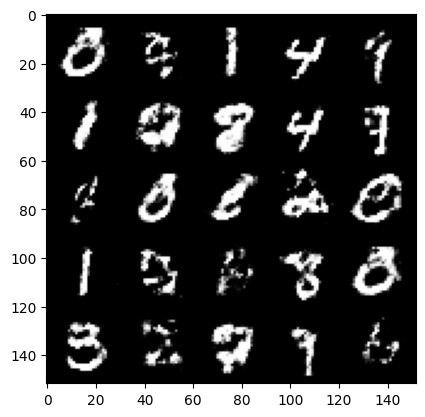

In [37]:
show_tensor_images(generator_model(get_noise(25, 64, "cuda")), 25)

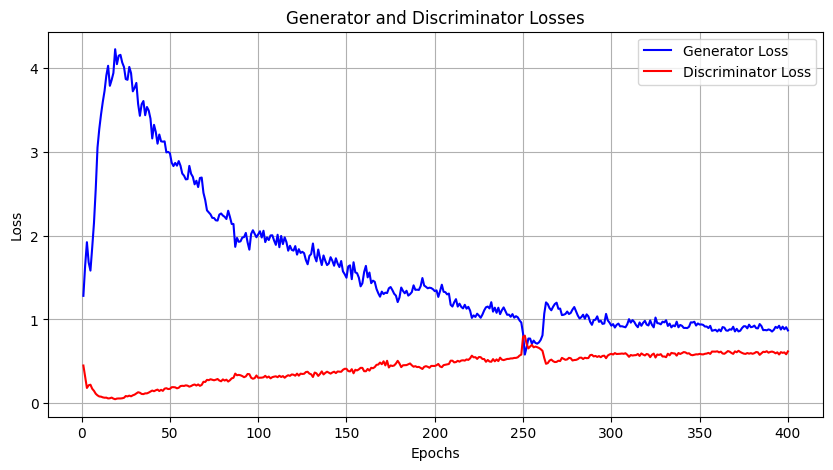

In [6]:
import numpy as np
import matplotlib.pyplot as plt

generator_losses = np.load("./losses/generator_losses.npy")
discriminator_losses = np.load("./losses/discriminator_losses.npy")
epochs = range(1, len(generator_losses) + 1)

def plot_losses(epochs, generator_losses, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, generator_losses, label="Generator Loss", color='blue')
    plt.plot(epochs, discriminator_losses, label="Discriminator Loss", color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()  # Shows the labels for the plot
    plt.grid(True)
    plt.show()

plot_losses(epochs, generator_losses, discriminator_losses)